In [1]:
import pandas as pd
import numpy as np
from iou import intersection_over_union
import torch
from matplotlib import pyplot as plt
import numpy as np

Читаю csv-файлы в датафреймы и изучаю как выглядят данные

In [2]:
gt = pd.read_csv('groundtruth.csv')
preds = pd.read_csv('predictions.csv')

In [3]:
preds

,clip_name,frame_num,obj_type,x,y,w,h,confidence
0,20191216_123222.mp4,4,SeatbeltNo,146,478,294,242,0.980469
1,20191216_123222.mp4,4,Eyes,202,356,106,52,0.003906
2,20191216_123222.mp4,4,Face,206,328,124,148,0.000000
3,20191216_123222.mp4,4,Mouth,208,414,106,52,0.003906
4,20191216_123222.mp4,5,SeatbeltNo,146,478,288,242,0.984375
...,...,...,...,...,...,...,...,...
120057,20191216_125644.mp4,5101,Mouth,272,426,116,58,0.003906
120058,20191216_125644.mp4,5102,SeatbeltNo,240,426,318,294,0.992188
120059,20191216_125644.mp4,5102,Glasses,252,362,150,72,0.788163
120060,20191216_125644.mp4,5102,Face,268,328,142,164,0.000000


In [4]:
gt

,clip_name,frame_num,obj_type,x,y,w,h,label
0,20191216_124707.mp4,1,Face,331,268,170,219,Straight
1,20191216_124707.mp4,1,Eyes,354,359,117,39,Open
2,20191216_124707.mp4,1,Mouth,379,435,63,23,Close
3,20191216_124707.mp4,2,Face,331,268,170,219,Straight
4,20191216_124707.mp4,2,Eyes,354,359,117,39,Open
...,...,...,...,...,...,...,...,...
110403,20191216_123222.mp4,5116,Mouth,285,447,58,24,Close
110404,20191216_123222.mp4,5117,Face,220,287,167,206,Straight
110405,20191216_123222.mp4,5117,Glasses,233,383,152,39,Unknown
110406,20191216_123222.mp4,5117,Eyes,266,373,108,39,Unknown


In [5]:
gt = gt[gt['label'] != 'Unknown']

In [6]:
gt[gt['obj_type'] == 'Face']['label'].value_counts()

Straight    17128
Side         3979
Down         1822
Up           1445
Name: label, dtype: int64

In [7]:
gt['obj_type'].value_counts()

Mouth        27920
Face         24374
Eyes         18591
Glasses      11865
Cellphone     4223
Name: obj_type, dtype: int64

In [8]:
preds['obj_type'].value_counts()

Face           28661
Mouth          28661
SeatbeltNo     28176
Glasses        16880
Eyes            8718
Cellphone       4992
Sunglasses      3358
SeatbeltYes      616
Name: obj_type, dtype: int64

In [9]:
obj_types = gt['obj_type'].unique()

In [10]:
preds = preds[preds['obj_type'].isin(obj_types)]

In [11]:
preds['obj_type'].value_counts()

Face         28661
Mouth        28661
Glasses      16880
Eyes          8718
Cellphone     4992
Name: obj_type, dtype: int64

In [12]:
gt = gt.drop(columns=['label'])

Пример кадра, на котором есть метки, которые модель не распознала (False Negative)

In [13]:
gt.loc[(gt['clip_name'] == '20191216_123222.mp4') & (gt['frame_num'] == 3592)]

,clip_name,frame_num,obj_type,x,y,w,h
103404,20191216_123222.mp4,3592,Mouth,269,480,56,25
103405,20191216_123222.mp4,3592,Cellphone,300,700,84,20


In [14]:
preds.loc[(preds['clip_name'] == '20191216_123222.mp4') & (preds['frame_num'] == 3592)]

,clip_name,frame_num,obj_type,x,y,w,h,confidence
14548,20191216_123222.mp4,3592,Glasses,224,402,146,62,0.769557
14549,20191216_123222.mp4,3592,Face,230,368,126,160,0.000000
14550,20191216_123222.mp4,3592,Mouth,238,464,114,56,0.003906


Пример кадра, на котором модель ложно распознала метки, которых нет (False Positive)

In [15]:
gt.loc[(gt['clip_name'] == '20191216_123222.mp4') & (gt['frame_num'] == 68)]

,clip_name,frame_num,obj_type,x,y,w,h
91718,20191216_123222.mp4,68,Face,163,280,235,202
91719,20191216_123222.mp4,68,Mouth,177,434,22,23


In [16]:
preds.loc[(preds['clip_name'] == '20191216_123222.mp4') & (preds['frame_num'] == 68)]

,clip_name,frame_num,obj_type,x,y,w,h,confidence
258,20191216_123222.mp4,68,Mouth,140,416,100,50,0.003906
259,20191216_123222.mp4,68,Eyes,144,364,100,50,0.312500
261,20191216_123222.mp4,68,Face,170,340,96,142,0.000000
262,20191216_123222.mp4,68,Cellphone,224,546,138,72,0.552914


In [17]:
preds.loc[(preds['clip_name'] == '20191216_123222.mp4') & (preds['obj_type'] == 'Cellphone')]

,clip_name,frame_num,obj_type,x,y,w,h,confidence
262,20191216_123222.mp4,68,Cellphone,224,546,138,72,0.552914
271,20191216_123222.mp4,70,Cellphone,222,542,142,68,0.552914
413,20191216_123222.mp4,106,Cellphone,222,548,136,56,0.558194
418,20191216_123222.mp4,107,Cellphone,220,546,134,62,0.525194
423,20191216_123222.mp4,108,Cellphone,228,544,132,60,0.543845
...,...,...,...,...,...,...,...,...
18618,20191216_123222.mp4,4457,Cellphone,202,410,46,106,0.510330
19027,20191216_123222.mp4,4559,Cellphone,192,408,54,100,0.509747
19032,20191216_123222.mp4,4560,Cellphone,186,412,58,100,0.590903
19538,20191216_123222.mp4,4686,Cellphone,236,508,130,74,0.579531


Соединяю разметку и предсказания в один датафрейм

In [18]:
df = gt.merge(preds, how='outer', left_on=['clip_name', 'frame_num', 'obj_type'], right_on=['clip_name', 'frame_num', 'obj_type'])

In [19]:
df.loc[(df['clip_name'] == '20191216_123222.mp4') & (df['frame_num'] == 3592)]

,clip_name,frame_num,obj_type,x_x,y_x,w_x,h_x,x_y,y_y,w_y,h_y,confidence
81600,20191216_123222.mp4,3592,Mouth,269.0,480.0,56.0,25.0,238.0,464.0,114.0,56.0,0.003906
81601,20191216_123222.mp4,3592,Cellphone,300.0,700.0,84.0,20.0,NaN,NaN,NaN,NaN,NaN
89180,20191216_123222.mp4,3592,Glasses,NaN,NaN,NaN,NaN,224.0,402.0,146.0,62.0,0.769557
89181,20191216_123222.mp4,3592,Face,NaN,NaN,NaN,NaN,230.0,368.0,126.0,160.0,0.000000


In [20]:
df.loc[(df['clip_name'] == '20191216_123222.mp4') & (df['frame_num'] == 68)]

,clip_name,frame_num,obj_type,x_x,y_x,w_x,h_x,x_y,y_y,w_y,h_y,confidence
72730,20191216_123222.mp4,68,Face,163.0,280.0,235.0,202.0,170.0,340.0,96.0,142.0,0.000000
72731,20191216_123222.mp4,68,Mouth,177.0,434.0,22.0,23.0,140.0,416.0,100.0,50.0,0.003906
87005,20191216_123222.mp4,68,Eyes,NaN,NaN,NaN,NaN,144.0,364.0,100.0,50.0,0.312500
87006,20191216_123222.mp4,68,Cellphone,NaN,NaN,NaN,NaN,224.0,546.0,138.0,72.0,0.552914


In [21]:
df = df.rename(columns={'x_x' : 'x_gt', 'y_x' : 'y_gt', 'w_x' : 'w_gt', 'h_x' : 'h_gt',
                        'x_y' : 'x_pred', 'y_y' : 'y_pred', 'w_y' : 'w_pred', 'h_y' : 'h_pred',})

Заполняю пропуски нулями

In [22]:
df = df.fillna(0)

In [23]:
df

,clip_name,frame_num,obj_type,x_gt,y_gt,w_gt,h_gt,x_pred,y_pred,w_pred,h_pred,confidence
0,20191216_124707.mp4,1,Face,331.0,268.0,170.0,219.0,0.0,0.0,0.0,0.0,0.000000
1,20191216_124707.mp4,1,Eyes,354.0,359.0,117.0,39.0,0.0,0.0,0.0,0.0,0.000000
2,20191216_124707.mp4,1,Mouth,379.0,435.0,63.0,23.0,0.0,0.0,0.0,0.0,0.000000
3,20191216_124707.mp4,2,Face,331.0,268.0,170.0,219.0,0.0,0.0,0.0,0.0,0.000000
4,20191216_124707.mp4,2,Eyes,354.0,359.0,117.0,39.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
101254,20191216_125644.mp4,5078,Glasses,0.0,0.0,0.0,0.0,266.0,376.0,132.0,68.0,0.628713
101255,20191216_125644.mp4,5079,Glasses,0.0,0.0,0.0,0.0,250.0,378.0,144.0,64.0,0.646723
101256,20191216_125644.mp4,5080,Glasses,0.0,0.0,0.0,0.0,248.0,376.0,148.0,62.0,0.678269
101257,20191216_125644.mp4,5081,Glasses,0.0,0.0,0.0,0.0,248.0,376.0,144.0,64.0,0.704333


In [24]:
df['obj_type'].unique()

array(['Face', 'Eyes', 'Mouth', 'Glasses', 'Cellphone'], dtype=object)

In [25]:
def mean_average_precision(data: pd.DataFrame, iou_threshold=0.4, plot_curves=False):
    '''Calculates mAP for each type of object based on dataframe'''
    epsilon = 1e-9
    class_list = data['obj_type'].unique()
    APs = {}
    
    #preparing axes for plots
    nrows = int(np.ceil(len(class_list) / 3))
    ncols = 3
    fig, axs = plt.subplots(nrows, ncols, figsize=(15, 10))
    for i in range(nrows):
        for j in range(ncols):
            axs[i, j].set_visible(False)
    ax_x = 0
    ax_y = 0
    
    for type in class_list:
        cur_class_df = data[data['obj_type'] == type]
        cur_class_df = cur_class_df.sort_values('confidence', ascending=False)
        num_detections = len(cur_class_df.loc[(cur_class_df['w_pred'] != 0) & (cur_class_df['h_pred'] != 0)])
        num_true_objects = len(cur_class_df.loc[(cur_class_df['w_gt'] != 0) & (cur_class_df['h_gt'] != 0)])
        
        TP = torch.zeros(num_detections)
        FP = torch.zeros(num_detections)
        
        detection_idx = 0
        for index, row in cur_class_df.iterrows():
            if row['w_pred'] != 0 and row['h_pred'] != 0:
                cords_pred = [row['x_pred'], row['y_pred'], row['w_pred'], row['h_pred']]
                cords_gt = [row['x_gt'], row['y_gt'], row['w_gt'], row['h_gt']]
                iou = intersection_over_union(cords_pred, cords_gt)
                if iou >= iou_threshold:
                    TP[detection_idx] = 1
                else:
                    FP[detection_idx] = 1
                
                detection_idx += 1
                
        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        
        recalls = TP_cumsum / (num_true_objects + epsilon)
        precisions = TP_cumsum / (TP_cumsum + FP_cumsum + epsilon)
        recalls = torch.cat((torch.tensor([0]), recalls))
        precisions = torch.cat((torch.tensor([1]), precisions))
        
        APs[type] = float(torch.trapz(precisions, recalls))
        
        #plotting current class AP curve
        axs[ax_x, ax_y].set_visible(True)
        axs[ax_x, ax_y].plot(recalls, precisions, label=f'AP = {round(APs[type], 4)}')
        axs[ax_x, ax_y].set_title(type)
        axs[ax_x, ax_y].legend(loc='upper right')
        axs[ax_x, ax_y].set_xlabel('recall')
        axs[ax_x, ax_y].set_ylabel('precision')
        ax_y += 1
        if ax_y == 3:
            ax_y = 0
            ax_x += 1

    return APs

Face: 0.6168462634086609
Eyes: 0.2274267077445984
Mouth: 0.0026034770999103785
Glasses: 0.7205209732055664
Cellphone: 0.8571968674659729


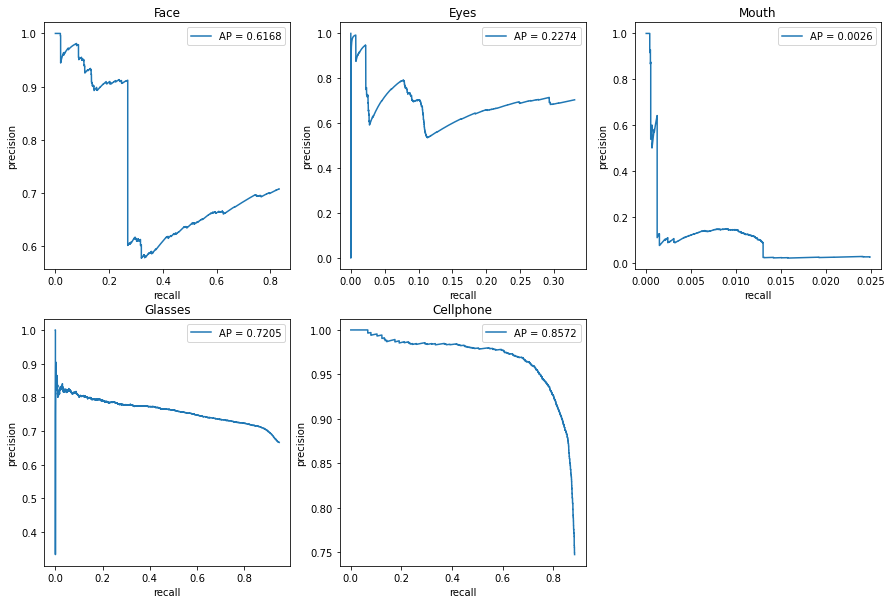

In [27]:
mAP = mean_average_precision(df, iou_threshold=0.4, plot_curves=True)

for type, val in mAP.items():
    print(f'{type}: {val}')